## Q1-5

In [5]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

# attack_category = ['normal', 'DOS', 'R2L', 'U2R', 'probe']
normal = ['normal']
DOS = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
R2L = ['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop']
U2R = ['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm']
probe = ['ipsweep','mscan','nmap','portsweep','saint','satan']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_binary = udf(lambda name: 0.0 if name == 'normal' else 1.0 if name in DOS else 2.0 if name in R2L else 3.0 if name in U2R else 4.0 if name in probe else -1.0)  # Unknown category or any other category not listed        output_df = dataset.withColumn('outcome', label_to_binary(col('class'))).drop("class")  
        output_df = dataset.withColumn('outcome', label_to_binary(col('class'))).drop("class")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 

In [6]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=d3e57d3896b53ad1cec8e05d6eaf9006b3564e6a0ccdc9e751a1d7d7e905eaa0
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [7]:
!python -m wget https://www.andrew.cmu.edu/user/mfarag/14763/KDDTest+.txt
!hadoop fs -put KDDTest+.txt /

!python -m wget https://www.andrew.cmu.edu/user/mfarag/14763/KDDTrain+.txt
!hadoop fs -put KDDTrain+.txt /

100% [......................................................] 3441513 / 3441513
Saved under KDDTest+.txt
100% [....................................................] 19109424 / 19109424
Saved under KDDTrain+.txt


In [8]:
spark = SparkSession.builder \
    .master("yarn") \
    .appName("SparkMLOct26-RF500-yarn") \
    .getOrCreate()

nslkdd_raw = spark.read.csv('/KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv('/KDDTest+.txt',header=False).toDF(*col_names)

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)

nslkdd_df = preprocess_pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = preprocess_pipeline_model.transform(nslkdd_test_raw)


nslkdd_df.cache()
nslkdd_df_test.cache()


23/10/26 19:25:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[features: vector, outcome: double]

In [9]:
nslkdd_df.printSchema()
nslkdd_df.show()

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)



+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(113,[1,13,14,17,...|    0.0|
|(113,[1,13,14,17,...|    0.0|
|(113,[13,14,15,17...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[13,14,16,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,16,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,13,14,17,...|    2.0|
|(113,[13,14,15,18...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,13,14,17,...|    4.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,2,13,14,1...|    0.0|
+--------------------+-------+
only showing top 20 rows



In [10]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'outcome')

lrModel = lr.fit(nslkdd_df) # fit the logistic regression model to the training dataset


In [11]:
predictions = lrModel.transform(nslkdd_df_test)

In [12]:
predictions.printSchema()

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [13]:
predictions.select("rawPrediction","probability","prediction","outcome").toPandas().head()

,rawPrediction,probability,prediction,outcome
0,"[-1.5050027106585269, 13.90152900162449, -11.2...","[2.0312712169865734e-07, 0.9971020807495979, 1...",1.0,1.0
1,"[-0.9299271829592559, 12.77134255004792, -10.3...","[1.1141082583334402e-06, 0.9938325886999708, 9...",1.0,1.0
2,"[5.457674370305926, -4.91101863948388, 1.52962...","[0.9767840538278842, 3.067131542829889e-05, 0....",0.0,0.0
3,"[6.77862427513028, -10.202507137725664, -4.554...","[0.02553865546947574, 1.0774232925132973e-09, ...",4.0,4.0
4,"[5.827813446632025, -1.5973767932028669, -5.32...","[0.9331110528727118, 0.0005561784859561025, 1....",0.0,4.0


In [14]:
predictions_train = lrModel.transform(nslkdd_df)# predictions using the training dataset
accuracy_train = (predictions_train.filter(predictions_train.outcome == predictions_train.prediction)
    .count() / float(predictions_train.count()))

accuracy_test = (predictions.filter(predictions.outcome == predictions.prediction)
    .count() / float(predictions.count()))
print(f"Train Accuracy : {np.round(accuracy_train*100,2)}%")
print(f"Test Accuracy : {np.round(accuracy_test*100,2)}%")



Train Accuracy : 98.76%
Test Accuracy : 75.92%


In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[9037  422    0    4  248]
 [1210 6238    1    0   11]
 [2747    3  129    3    3]
 [  44    2    4   17    0]
 [ 492  125  108    1 1695]]


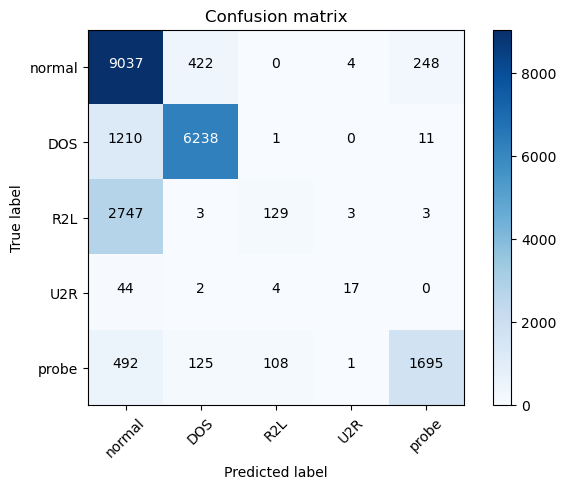

In [16]:
class_names=[0.0,1.0,2.0,3.0,4.0]
class_names_str=["normal","DOS","R2L","U2R","probe"]

outcome_true = predictions.select("outcome")
outcome_true = outcome_true.toPandas()

pred = predictions.select("prediction")
pred = pred.toPandas()

cnf_matrix = confusion_matrix(outcome_true, pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str,
                      title='Confusion matrix')
plt.show()

In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='outcome', metricName='f1')
print("Area under the curve is: ", evaluator.evaluate(predictions))


Area under the curve is:  0.7195155376924175


## Random Forest

In [18]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'outcome')
rf_model = rf.fit(nslkdd_df)

In [19]:
rf_prediction_train = rf_model.transform(nslkdd_df)
rf_prediction_test = rf_model.transform(nslkdd_df_test)

rf_accuracy_train = (rf_prediction_train.filter(rf_prediction_train.outcome == rf_prediction_train.prediction)
    .count()/ float(rf_prediction_train.count()))
rf_accuracy_test = (rf_prediction_test.filter(rf_prediction_test.outcome == rf_prediction_test.prediction)
    .count() / float(rf_prediction_test.count()))

rf_auc = evaluator.evaluate(rf_prediction_test)

print(f"Train accuracy = {np.round(rf_accuracy_train*100,2)}%, test accuracy = {np.round(rf_accuracy_test*100,2)}%, AUC = {np.round(rf_auc,2)}")

Train accuracy = 95.05%, test accuracy = 69.09%, AUC = 0.64
